In [5]:
import math, random

import sys
#sys.path.append('/content/drive/My Drive/DQN/input/')
sys.path.append('/home/kesci/input')
from common8945.wrappers import make_atari, wrap_deepmind, wrap_pytorch

import gym
import numpy as np

from itertools import count

from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()
    
def plot2(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('frame %s. loss for every 1000 steps' % (frame_idx))
    plt.plot(losses)
    plt.show()

In [7]:
class ExperienceMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            state, action, reward, next_state, done = self.memory[random.randint(0, self.size() - 1)]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):

    def __init__(self, action_space_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size = 8, stride = 4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        self.output = nn.Linear(512, action_space_size)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        return self.output(x)   

In [10]:
class Agent: 
   
    def __init__(self, action_space, model_path = None):
        self.EPSILON_BEGIN = 0.99
        self.EPSILON_END = 0.03
        self.EPSILON_TOTAL = 300000
        self.EPSILON_COUNT = 0
        self.DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 0.00005
        self.GAMMA = 0.99
        self.ACTION_SPACE = action_space
        self.MEMORY_SIZE = 50000
  
        self.memory = ExperienceMemory(self.MEMORY_SIZE)
        self.policy_net = DQN(self.ACTION_SPACE).to(self.DEV)
        self.target_net = DQN(self.ACTION_SPACE).to(self.DEV)
        self.policy_net = torch.load(model_path, map_location=torch.device(self.DEV))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.LEARNING_RATE)

    def take_action(self, state):
        self.EPSILON_COUNT += 1
        epsilon = self.EPSILON_END + (self.EPSILON_BEGIN - self.EPSILON_END) * math.exp(-1. * self.EPSILON_COUNT / self.EPSILON_TOTAL)
        if random.random() > epsilon:    
            with torch.no_grad():
                return self.policy_net(state).max(1)[1]
        else:
            return torch.tensor(random.randrange(self.ACTION_SPACE), device = self.DEV, dtype = torch.long)

    def act(self, frame):
        state = torch.tensor(frame / 255.0, device = self.DEV, dtype = torch.float).unsqueeze(0)
        with torch.no_grad():
          return self.policy_net(state).max(1)[1]
            
    def optimize(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.BATCH_SIZE)
        batch_states = torch.cat(states).to(self.DEV)
        batch_next_states = torch.cat(next_states).to(self.DEV)
        batch_actions = torch.tensor(actions, device = self.DEV, dtype = torch.long)
        batch_rewards = torch.tensor(rewards, device = self.DEV, dtype = torch.float) 
        batch_dones = torch.tensor(dones, device = self.DEV, dtype = torch.bool)
        
        policy_output = self.policy_net(batch_states)
        policy_values = policy_output[range(self.BATCH_SIZE), batch_actions]

        target_output = self.target_net(batch_next_states).max(1)[0]
        target_values = batch_rewards + self.GAMMA * target_output  
        target_values2 = torch.where(batch_dones, batch_rewards, target_values)
      
        loss = F.smooth_l1_loss(policy_values, target_values2)
        tmp = loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return tmp.item()
    
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state.to('cpu'), action.to('cpu'), reward, next_state.to('cpu'), done)

## Train Pong

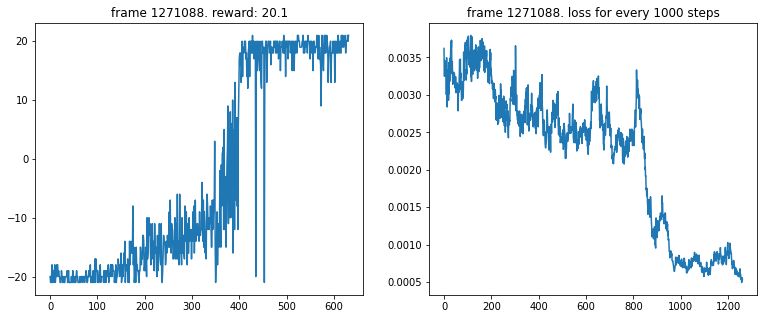

In [0]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

TARGET_UPDATE = 1000
EPISODE = 10000
LEARNING_START = 10000

agent = Agent(env.action_space.n)
all_losses = []
all_rewards = []
frame_idx = 0
episode_reward = 0
episode_loss = 0

for episode in range(1, EPISODE):
    episode_reward = 0
    frame = env.reset()
    state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)    
    
    for t in count():
        frame_idx += 1
        action = agent.take_action(state)
        next_frame, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = torch.tensor(next_frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if frame_idx > LEARNING_START:
            episode_loss += agent.optimize()
            
            if frame_idx % 1000 == 0:
                episode_loss = episode_loss / 1000.0;
                all_losses.append(episode_loss)
                episode_loss = 0
            
            if frame_idx % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        if done:
            break;

    all_rewards.append(episode_reward)
    plot2(frame_idx, all_rewards, all_losses)
    if episode % 100 == 0:
        torch.save(agent.policy_net, '/content/drive/My Drive/DQN/0427/5/network' + str(episode) + '.pth')
          
env.close()

## Evaluate Pong
尊敬的助教：
	或许因为colab与kesci的环境差异，load模型可能有时候会出现'source code has changed'的warning，如果这样，请多运行几次就可以了QWQ.

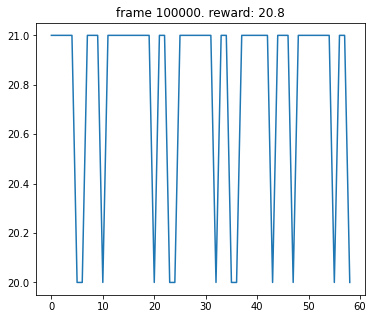

In [0]:
#network365.pth

num_frames = 100000

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

#load model
current_model = Agent(env.action_space.n, model_path = '/home/kesci/input/atari_model6748/pong.pth')
current_model.policy_net.eval()

all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards)
        

env.close()

## Train Freeway

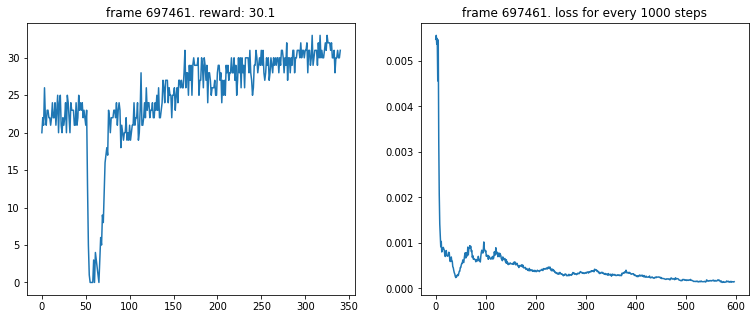

In [0]:
env_id = "FreewayNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

EPISODE = 100000
LEARNING_START = 100000
TARGET_UPDATE = 1000

directory = '/content/drive/My Drive/DQN/0520/17/'
frame_idx = 0
episode_reward = 0
episode_loss = 0
all_losses = []
all_rewards = []
agent = Agent(env.action_space.n)

for episode in range(1, EPISODE):
    episode_reward = 0
    frame = env.reset()
    state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)    
    
    for t in count():
        frame_idx += 1
        action = agent.take_action(state)
        next_frame, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = torch.tensor(next_frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if frame_idx > LEARNING_START:
            loss = agent.optimize()
            episode_loss += loss
            if frame_idx % 1000 == 0:
                episode_loss = episode_loss / 1000.0;
                all_losses.append(episode_loss)
                episode_loss = 0
            
            if frame_idx % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        if done:
            break;
    
    all_rewards.append(episode_reward)
    plot2(frame_idx, all_rewards, all_losses)
    if episode % 100 == 0 or episode_reward > 30:
        torch.save(agent.policy_net, directory + 'network' + str(episode) + '.pth')
        torch.save(all_rewards, directory + 'reward' + str(episode) + '.pth')
        torch.save(all_losses, directory + 'loss' + str(episode) + '.pth')
          
env.close()

## Evaluate Freeway

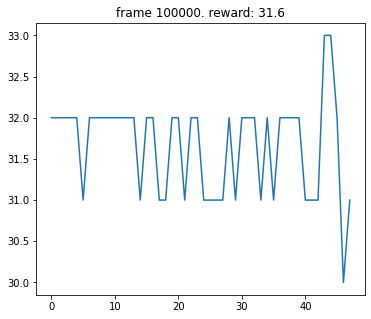

In [0]:
#network342.pth

num_frames = 100000

env_id = "FreewayNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

#load model
current_model = Agent(env.action_space.n, model_path = '/home/kesci/input/atari_model6748/freeway.pth')
current_model.policy_net.eval()

all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards)
        

env.close()

## Train Krull

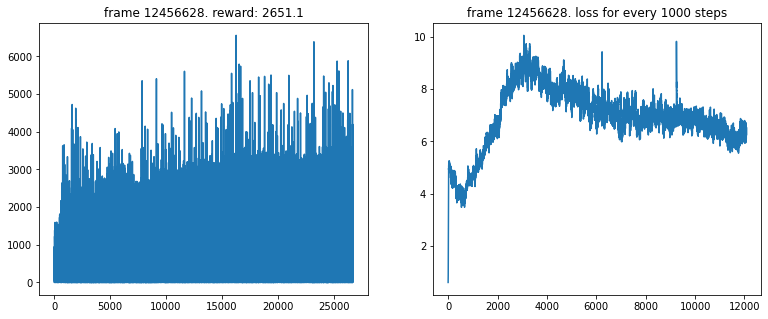

In [17]:
env_id = "KrullNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards = False, frame_stack = True)
env    = wrap_pytorch(env)

EPISODE = 100000
LEARNING_START = 30000
TARGET_UPDATE = 1000

directory = '/content/drive/My Drive/DQN/0520/9/'
frame_idx = 0
episode_reward = 0
episode_loss = 0
all_losses = []
all_rewards = []]
agent = Agent(env.action_space.n)

for episode in range(1, EPISODE):
    episode_reward = 0
    frame = env.reset()
    state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)    
    
    for t in count():
        frame_idx += 1
        action = agent.take_action(state)
        next_frame, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = torch.tensor(next_frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if frame_idx > LEARNING_START:
            loss = agent.optimize()
            episode_loss += loss
            if frame_idx % 1000 == 0:
                episode_loss = episode_loss / 1000.0;
                all_losses.append(episode_loss)
                episode_loss = 0
            
            if frame_idx % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        if done:
            break;
    
    all_rewards.append(episode_reward)
    plot2(frame_idx, all_rewards, all_losses)
    if episode % 100 == 0 or episode_reward > 5000:
        torch.save(agent.policy_net, directory + 'network' + str(episode) + '.pth')
        torch.save(all_rewards, directory + 'reward' + str(episode) + '.pth')
        torch.save(all_losses, directory + 'loss' + str(episode) + '.pth')
          
env.close()

## Evaluate Krull

<Figure size 1440x360 with 1 Axes>
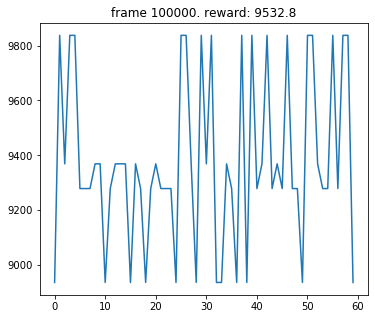

In [12]:
#network27674.pth

num_frames = 100000

env_id = "KrullNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, episode_life = False, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

#load model
current_model = Agent(env.action_space.n, model_path = '/home/kesci/input/atari_model6748/krull.pth')
current_model.policy_net.eval()

all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards)
        

env.close()

## Train Tutankham

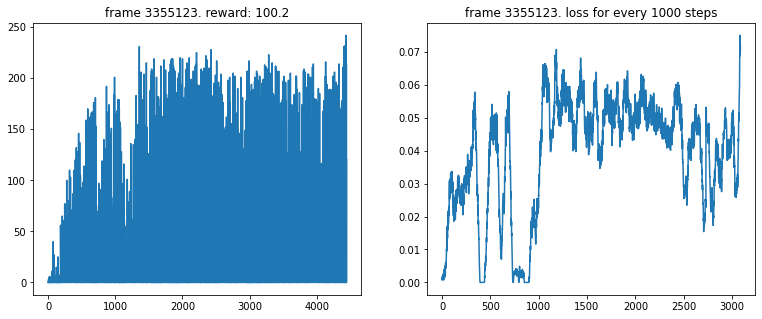

In [16]:
env_id = "TutankhamNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

EPISODE = 100000
LEARNING_START = 30000
TARGET_UPDATE = 1000

directory = '/content/drive/My Drive/DQN/0520/26/'
frame_idx = 0
episode_reward = 0
episode_loss = 0
all_losses = [] 
all_rewards = []
agent = Agent(env.action_space.n)

for episode in range(1, EPISODE):
    episode_reward = 0
    frame = env.reset()
    state = torch.tensor(frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)    
    
    for t in count():
        frame_idx += 1
        action = agent.take_action(state)
        next_frame, reward, done, _ = env.step(action)
        episode_reward += reward
        next_state = torch.tensor(next_frame / 255.0, device = DEV, dtype = torch.float).unsqueeze(0)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if frame_idx > LEARNING_START:
            loss = agent.optimize()
            episode_loss += loss
            if frame_idx % 1000 == 0:
                episode_loss = episode_loss / 1000.0;
                all_losses.append(episode_loss)
                episode_loss = 0
            
            if frame_idx % TARGET_UPDATE == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        if done or t > 10000:
            break;
    
    all_rewards.append(episode_reward)
    plot2(frame_idx, all_rewards, all_losses)
    if episode % 100 == 0 or episode_reward >= 200:
        torch.save(agent.policy_net, directory + 'network' + str(episode) + '.pth')
        torch.save(all_rewards, directory + 'reward' + str(episode) + '.pth')
        torch.save(all_losses, directory + 'loss' + str(episode) + '.pth')
          
env.close()

## Evaluate Tutankham

<Figure size 1440x360 with 1 Axes>
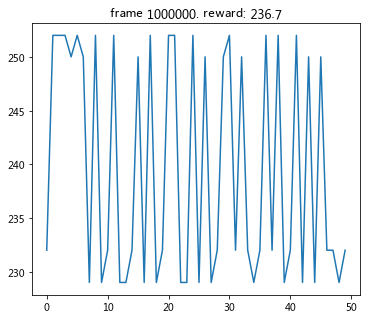

In [27]:
#network4473.pth

num_frames = 1000000 #100W frames 

env_id = "TutankhamNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, episode_life = False, clip_rewards=False, frame_stack = True)
env    = wrap_pytorch(env)

#load model
current_model = Agent(env.action_space.n, model_path = '/home/kesci/input/atari_model6748/tutankham.pth')
current_model.policy_net.eval()

all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards)
        

env.close()